<center><h1>Ablation Experiments</h1></center>

We've attempted to replicate 2-Layer SaShiMi results from Section 5.2 (Table 5) in the paper. This notebook does not include the code for training the model. All pre-trained models used in this notebook were trained with `train.py` script.

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import IPython.display as ipd
from torchaudio.functional import mu_law_encoding, mu_law_decoding
from scipy.io import wavfile
import os

# Custom modules
from sashimi import *
from wav_dataset import *

Using PyKeOps Cauchy kernel.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# Loading a Pre-Trained model and Testing

The following function will load a pre-trained model. You should have downloaded the pre-trained models using `download_data.sh` script. All pre-trained models should be available in `models` folder.

In [4]:
def load_model(model, name, _epoch=None):
    global epoch, device, model_name, model_folder
    model_name = name
    model_folder = "./models/" + name

    with open(os.path.join(model_folder, "train_loss.txt"), 'r') as f:
        train = [float(i.strip()) for i in f.readlines()]

    with open(os.path.join(model_folder, "validation_loss.txt"), 'r') as f:
        valid = [float(i.strip()) for i in f.readlines()]

    plt.title(label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train)
    plt.plot(valid)

    epoch = len(train) if _epoch is None else _epoch
    checkpoint_filename = os.path.join(model_folder, f"epoch{epoch:04d}.pt")
    print("Loading model:", checkpoint_filename)
    checkpoint = torch.load(checkpoint_filename, map_location=device)

    return model.load_state_dict(checkpoint["model_state"])

## NLL Test

We want to compute the average negative log likelihood (NLL) value on the test dataset.

Note that [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) simply calculates the NLL by applying softmax internally:

$$
l_n = - \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
$$

PyTorch uses natural log by default. We convert this to NLL in bits by dividing the result by $\log(2)$. 

In [5]:
test_dataset = YoutubeMixDataset("./datasets/youtube-mix/test", duration=8, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def test_nll(model):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        nll = 0.0
        for x, y in tqdm(test_dataloader, leave=False):
            y_hat = model(x)
            nll += criterion(y_hat.view(-1, 256), y.view(-1))
        nll /= len(test_dataloader)

        print("Average NLL:", nll.item())
        print("Average NLL in base 2:", (nll / torch.tensor(2.0).log()).item())
        print("Average NLL converted to probability:", (-nll).exp().item())

len(test_dataset)

111

# 2-Layer SaShiMi with 32 state dimensions

- AdamW optimizer was used with a learning rate of 0.001.
- Starting at epoch 38, the learning rate was reduced to 0.00025.
- Starting at epoch 86, the learning rate was reduced to 0.0002.
- Starting at epoch 205, the learning rate was reduced to 0.0001.

In [6]:
model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=32,
    sequence_length=16000*8,
    block_count=2,
    encoder=Embedding(256, 64),
).to(device)

print("Total parameters:", sum([i.nelement() for i in model.parameters()]))
print("Parameters to be learned:", sum([i.nelement() if i.requires_grad else 0 for i in model.parameters()]))

Total parameters: 1288582
Parameters to be learned: 1288582


The parameter count is exactly the same as in Table 5 when rounded to 2 decimal places.

Loading model: ../models/ym-2l-32s/epoch0215.pt


<All keys matched successfully>

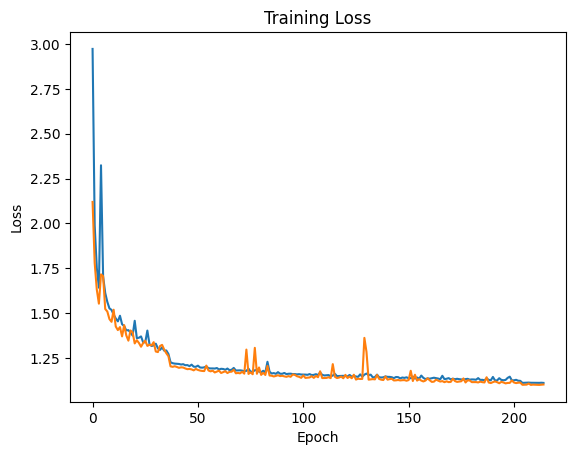

In [7]:
load_model(model, "ym-2l-32s")

In [8]:
test_nll(model)

  0%|          | 0/111 [00:00<?, ?it/s]

Average NLL: 1.1116973161697388
Average NLL in base 2: 1.6038402318954468
Average NLL converted to probability: 0.3290000855922699


For comparison, **the NLL value reported on the paper is 1.446** (in base 2) for SaShiMi model with 2 layers.

However, please note that they train this model longer in the paper (**500 epochs** on page 9, **600K steps** on page 19). We could only train it for 215 epochs. We believe it's reasonable to expect that our model can achieve the same or better NLL value with longer training and better hyperparameter choices.

### Sampling

There's a separate section at the end of this notebook for sampling. Since the audio files cannot be saved inside a Jupyter Notebook unlike images, we provide samples separately in `outputs` folder.

# 2-Layer SaShiMi with 64 states

Although the previous model has the same parameter count as reported in the paper, the parameter count depends on how the complex parameters are counted. In our code, a complex parameter is counted as 2 parameters. It's possible that the authors of the paper counted a complex parameter as a single parameter. In that case, 2-Layer SaShiMi with 64 state dimensions would have the same parameter count as in the paper.

- AdamW optimizer was used with a learning rate of 0.001.
- Starting at epoch 111, the learning rate was reduced to 0.0002.
- Starting at epoch 188, the learning rate was reduced to 0.0001.

In [14]:
model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000*8,
    block_count=2,
    encoder=Embedding(256, 64),
).to(device)

print("Total parameters:", sum([i.nelement() for i in model.parameters()]))
print("Parameters to be learned:", sum([i.nelement() if i.requires_grad else 0 for i in model.parameters()]))

Total parameters: 1347078
Parameters to be learned: 1347078


Loading model: ../models/ym-2l/epoch0203.pt


<All keys matched successfully>

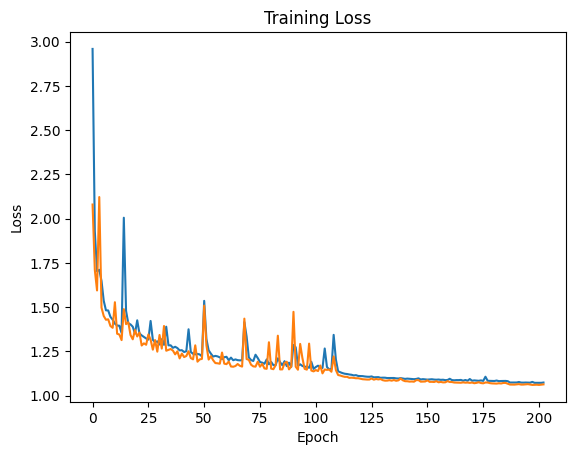

In [15]:
load_model(model, "ym-2l")

In [16]:
test_nll(model)

  0%|          | 0/111 [00:00<?, ?it/s]

Average NLL: 1.0747634172439575
Average NLL in base 2: 1.5505558252334595
Average NLL converted to probability: 0.34137850999832153


# 2-Layer SaShiMi with GLU on Youtube Mix

In Appendix C.2.1, authors mention that swapping activations with [GLU](https://pytorch.org/docs/stable/generated/torch.nn.GLU.html) improves both NLL and performance. We investigate this by training a 2-Layer SaShiMi with GLU on Youtube Mix.

Note that since GLU layer halves the dimensions, we increase the output dimensions of the linear layers that precede GLU layers. This increases the parameter count of the model.

- AdamW optimizer was used with a learning rate of 0.001.
- Starting at epoch 100, the learning rate was reduced to 0.0002.
- Starting at epoch 141, the learning rate was reduced to 0.0001.

In [17]:
model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000*8,
    block_count=2,
    block_class=S4BlockGLU,
    encoder=Embedding(256, 64),
).to(device)

print("Total parameters:", sum([i.nelement() for i in model.parameters()]))
print("Parameters to be learned:", sum([i.nelement() if i.requires_grad else 0 for i in model.parameters()]))

Total parameters: 1865862
Parameters to be learned: 1865862


Loading model: ../models/ym-2l-glu/epoch0150.pt


<All keys matched successfully>

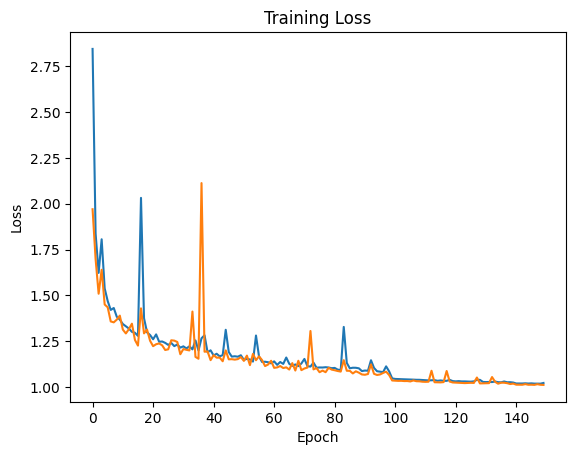

In [18]:
load_model(model, "ym-2l-glu")

In [19]:
test_nll(model)

  0%|          | 0/111 [00:00<?, ?it/s]

Average NLL: 1.0214753150939941
Average NLL in base 2: 1.473677396774292
Average NLL converted to probability: 0.3600633442401886


This time, our average NLL in base 2 is quite close to 1.446, the value reported in the paper.

# Sampling

After loading a model from any of the sections above, you can use the following code block to generate 32 samples at once and save them.

In [11]:
seed = 42
torch.manual_seed(seed)
model.eval()
with torch.no_grad():
    gen = generate_audio_sample(model, 8*16000, batch_size=32)
    gen = mu_law_decoding(gen, 256).cpu()

dirname = "outputs/" + model_name
if not os.path.exists(dirname):
    os.makedirs(dirname)

for i, g in enumerate(gen):
    wavfile.write(f"{dirname}/epoch{epoch:04d}-seed{seed}-{i}.wav", 16000, g.numpy())

  0%|          | 0/128000 [00:00<?, ?it/s]

Let's listen to the generated samples.

In [12]:
selected_index = 0

In [ ]:
selected = gen[selected_index]
print("Sample", selected_index)
selected_index = (selected_index + 1) % gen.size(dim=0)
plt.figure()
plt.plot(selected)
ipd.Audio(selected.numpy(), rate=16000)

You can run the previous block repeatedly to switch to the next sample.

Since the audio files cannot be saved inside a Jupyter Notebook unlike images, we provide the samples separately. **You can listen to our samples [in this link](https://necrashter.github.io/sashimi-796).**